In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



In [ ]:
# Load dataset
df = pd.read_csv(r"data\data_trustpilot.csv") 
df.head()


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,...,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,CA,Rob Crane,2,Redirected,repeat,1,Flashbay,The company rep I worked with made my transact...,company rep worked made transaction smooth qui...,...,2024-10-23 04:17:44,2024-10-22,10,21,Evening,1,Business Day,129,late_review,0
1,5,US,Pat Anderson,1,Verified,one-time,0,Flashbay,I highly recommend using Flashbay. Immediately...,highly recommend using flashbay immediately or...,...,2024-10-16 19:34:05,2024-10-16,10,12,Business Hours,2,Business Day,0,quick_review,1
2,5,CZ,Margarita Orlova,1,Verified,one-time,0,Flashbay,I had the pleasure of working with Shelby Gibs...,pleasure working shelby gibson large order nee...,...,2024-10-17 10:27:44,2024-10-17,10,10,Business Hours,3,Business Day,7,late_review,0
3,5,US,Paola Rivas,1,Verified,one-time,0,Flashbay,I had a fantastic experience with Brian Truong...,fantastic experience brian truong attentive tr...,...,2024-10-21 22:38:50,2024-10-21,10,15,Business Hours,0,Business Day,0,quick_review,1
4,5,CA,Fiona Mckelvey Keenan,3,Not Verified,repeat,1,Flashbay,My number-one go-to for computer accessories. ...,numberone goto computer accessories rachel sup...,...,2024-10-23 04:09:05,2024-10-22,10,21,Evening,1,Business Day,103,late_review,0


In [11]:
texts = df['text_processed'].astype(str).tolist()  
ratings = df['rating'].astype(int).values  


In [ ]:
# Tokenize and Convert Text to Sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

X = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = 60  
X = pad_sequences(X, maxlen=max_length, padding='post')

# Encode ratings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(ratings)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load GloVe Embeddings
embedding_dim = 300
glove_file = "glove.6B.300d.txt"  

embeddings_index = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))  # Freeze GloVe embeddings
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=5, activation='softmax'))  # 5 classes for 5-star ratings

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Validation Accuracy: ", accuracy * 100, "%")

# Save the model
model.save("rnn_glove_rating.keras")


c:\Users\Admin\.conda\envs\supply_chain\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 91s 54ms/step - accuracy: 0.6243 - loss: 1.0649 - val_accuracy: 0.6993 - val_loss: 0.8510
Epoch 2/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.6957 - loss: 0.8527 - val_accuracy: 0.7138 - val_loss: 0.8218
Epoch 3/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.7051 - loss: 0.8168 - val_accuracy: 0.7326 - val_loss: 0.7202
Epoch 4/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.7308 - loss: 0.7293 - val_accuracy: 0.7406 - val_loss: 0.6959
Epoch 5/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.7384 - loss: 0.7026 - val_accuracy: 0.7420 - val_loss: 0.6858
Epoch 6/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 85s 53ms/step - accuracy: 0.7427 - loss: 0.6837 - val_accuracy: 0.7458 - val_loss: 0.6709
Epoch 7/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.7515 - loss: 0.6590 - val_accuracy: 0.7516 - val_loss: 0.6663
Epoch 8/10
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 85s 52ms/step - accuracy: 0.7596 -

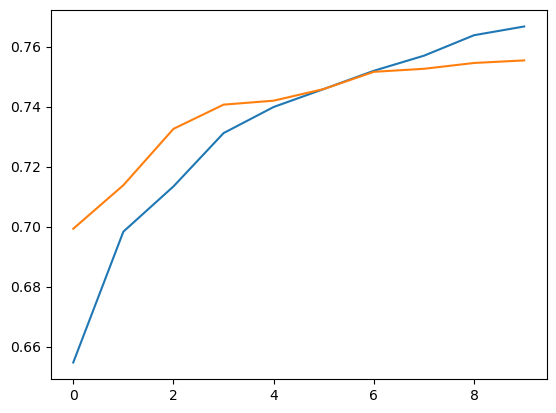

In [17]:
import matplotlib.pyplot as plt
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(train_acc)
plt.plot(val_acc)

In [18]:
y_pred = model.predict(X_test)

403/403 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


In [25]:
import numpy as np
test_pred_class= y_pred.argmax(axis = 1)
y_test_class = y_test

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_class, test_pred_class))
print(confusion_matrix(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3261
           1       0.24      0.03      0.05       863
           2       0.41      0.52      0.46      1271
           3       0.47      0.29      0.36      1274
           4       0.88      0.94      0.91      6213

    accuracy                           0.76     12882
   macro avg       0.55      0.53      0.52     12882
weighted avg       0.72      0.76      0.73     12882

[[2855   30  264   27   85]
 [ 426   25  327   33   52]
 [ 296   40  655  181   99]
 [  85    7  253  368  561]
 [ 125    2   83  175 5828]]
